In [1]:
import pandas as pd
import sys, os, subprocess, shutil, glob, bz2
from Bio import SeqIO
import numpy as np
import json


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline


# Navigate back to workbookDir in case of re-running a code block:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)  # If you changed the current working dir, this will take you back to the workbook dir.

workbookDir: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/3-stats_collection


### Requirements
1. gfsa
2. hgrewsa

In [2]:
DNAcompRNA = {a: b for a, b in zip('ATGC', 'UACG')}
def anticodon2codon(anticodon):
    codon = ''.join([DNAcompRNA[b] for b in anticodon[::-1]])
    return(codon)

In [3]:
#### Comments ######

# Parse all data and for each sample generate the following dataframe:
# readID, sample_name, replicate, barcode, tRNA_annotation, align_score, unique_annotation, tRNA_annotation_len, align_5p_idx, align_3p_idx, align_5p_nt, align_3p_nt, codon, anticodon, amino_acid, 5p_cover, 3p_cover, 5p_non-temp, 3p_non-temp

# readID -> (string) fastq raw data read header/ID
# sample_name -> (string) non unique sample name
# replicate -> (integer) replicate number (sample_name - replicate should be unique)
# barcode -> (string) barcode name
# tRNA_annotation -> (string) tRNA annotation string, either unique or multiple separated by @
# align_score -> (integer) alignment score
# unique_annotation -> (True/False) if annotation is unique or (multiple or centroid)
# tRNA_annotation_len -> (integer) the length of the tRNA annotated, if multiple annotations take the first
# align_5p_idx -> (integer) first base (by index) of annotated tRNA in the alignement
# align_3p_idx -> (integer) last base (by index) of annotated tRNA in the alignement (if CC add one to index)
# align_5p_nt -> (string) first base of annotated tRNA in the alignement
# align_3p_nt -> (string) last base of annotated tRNA in the alignement
# codon -> (string) codon
# anticodon -> (string) anticodon
# amino_acid -> (string) amino acid
# 5p_cover -> (True/False) if align_5p_idx == 1
# 3p_cover -> (True/False) if align_3p_idx == tRNA_annotation_len
# 5p_non-temp -> (string) 5' bases not part of the alignment to the annotation i.e. non-template bases
# 3p_non-temp -> (string) 3' bases not part of the alignment to the annotation i.e. non-template bases







# Write by appending to previous sample, at the end bzip the whole thing.
# Generate a smaller "charging statistics" dataframe by selecting:
# (df['3p_cover'] == True) & (df['align_score'] >= MIN_SCORE)
# and then aggregating on 3p_end == 'CCA' or 3p_end == 'CC'
# Also write the file. When this is done all statistics and plots can be derived from this.


# Stats general:
# Percent covering 3' (read covering end[-1]), percent with 3' truncation
# Percent of those covering 3' are full length
# Percent sequences with 0, 1, 2, ..., n non-template extensions (defined as not aligned) and their composition e.g. columns of 0, 1, 2,.. n and rows of ATGC.
# Break ^ down by preceeding base and plot as frequency logo plot for ATCG and all
# Break ^^ down by 5p_cover True/False


# TODO:
# Plot/use the NaCl data
# Test for bias in any of the barcodes
# Add unspliced tRNA as template and dumb seqeunces that map to unspliced tRNA
# Plot for specific tRNA sequences to see if any are more or less charged i.e. has regulatory potential.
# Read count ratio cyto vs. mito

In [4]:
# Variables that changes from batch to batch:
MIN_SCORE = 25
data_folder = 'data/pilot_exp'
project_folder = 'projects/pilot_exp'
tRNA_database = '../../../2-align_reads/tRNA_database/hg19_mature-tRNA.fa'

In [5]:
# Variables that should not change:
data_dir = 'stats_collection'
align_dir = 'SWalign'
umi_dir = 'UMI_trimmed'
sample_list = 'sample_list.xlsx'

In [6]:
### Read sample information ###
sample_df = pd.read_excel('../' + project_folder + '/' + sample_list)
sample_dict = {un: {'sample_name': n, 'replicate': r, 'barcode': b} for un, n, r, b in zip(sample_df['sample_name_unique'].values, sample_df['sample_name'].values, sample_df['replicate'].values, sample_df['barcode'].values)}

# Create folder for data and stats:
os.chdir('../' + data_folder)
stats_dir = '../../' + project_folder + '/stats_collection'
try:
    os.mkdir(stats_dir) # For stats
except:
    shutil.rmtree(stats_dir)
    os.mkdir(stats_dir)
# For manipulations and final data:
try:
    os.mkdir(data_dir) # For data
except:
    shutil.rmtree(data_dir)
    os.mkdir(data_dir)
os.chdir(data_dir)

In [7]:
# Read the tRNA database to find the length of each sequence:
tRNA_data = dict()
for record in SeqIO.parse(tRNA_database, "fasta"):
    tRNA_data[record.id] = dict()
    tRNA_data[record.id]['len'] = len(record.seq)
    tRNA_data[record.id]['codon'] = anticodon2codon(record.id.split('-')[2])
    tRNA_data[record.id]['anticodon'] = record.id.split('-')[2]
    tRNA_data[record.id]['amino_acid'] = record.id.split('-')[1]

In [8]:
stat_csv_fnam = 'stats_collection.csv.bz2'
agg_csv_fnam = 'stats_filtered_CC-CCA-aggregate.csv'
try:
    os.remove(stat_csv_fnam)
    os.remove(agg_csv_fnam)
except:
    pass

# Open filehandles and printer headers:
fh_stats_out = bz2.open(stat_csv_fnam, 'ab')
header = ['readID', 'sample_name', 'replicate', 'barcode', 'tRNA_annotation', 'align_score', 'unique_annotation', 'tRNA_annotation_len', 'align_5p_idx', 'align_3p_idx', 'align_5p_nt', 'align_3p_nt', 'codon', 'anticodon', 'amino_acid', '5p_cover', '3p_cover', '5p_non-temp', '3p_non-temp']
header_bin = str.encode(','.join(header))
fh_stats_out.write(header_bin)

fh_agg_out = open(agg_csv_fnam, 'a')
agg_cols = ['sample_name', 'replicate', 'barcode', 'tRNA_annotation', 'tRNA_annotation_len', 'unique_annotation', 'align_3p_nt', 'codon', 'anticodon', 'amino_acid', 'count']
print(','.join(agg_cols), file=fh_agg_out)

# Files to collect stats from:
json_files = glob.glob('../' + align_dir + '/*.json.bz2')
for json_file in json_files:
    fnam_base = '_'.join(json_file.split('/')[-1].split('_')[0:-1])
    uidx = fnam_base.index('UMI')
    unique_sample_name = fnam_base[0:uidx-1]
    
    with bz2.open(json_file, 'rt', encoding="utf-8") as fh_gz:
        SWres = json.loads(fh_gz.read())
    
    # Extract non-template bases from UMI processed reads:
    fastq_fnam = '../' + umi_dir + '/' + fnam_base + '.fastq.bz2'
    with bz2.open(fastq_fnam, 'rt') as fh_gz:
        for UMIread in SeqIO.parse(fh_gz, "fastq"):
            if UMIread.id in SWres:
                qpos = SWres[UMIread.id]['qpos'][0]
                SWres[UMIread.id]['5p_non-temp'] = str(UMIread.seq)[0:(qpos[0]-1)]
                SWres[UMIread.id]['3p_non-temp'] = str(UMIread.seq)[qpos[1]:]

    ### Collect stats on a per sample basis and store in tmp file ###
    with open('tmp_stat.csv', 'w') as tmp_csv:
        print(','.join(header), file=tmp_csv)
        for i, readID in enumerate(SWres):
            sample_name = sample_dict[unique_sample_name]['sample_name']
            replicate = sample_dict[unique_sample_name]['replicate']
            barcode = sample_dict[unique_sample_name]['barcode']
            tRNA_annotation = SWres[readID]['name']
            tRNA_annotation_first = tRNA_annotation.split('@')[0]
            align_score = SWres[readID]['score']
            unique_annotation = '@' not in tRNA_annotation
            tRNA_annotation_len = tRNA_data[tRNA_annotation_first]['len']
            align_5p_idx, align_3p_idx = SWres[readID]['dpos'][0]
            align_5p_nt = SWres[readID]['qseq'][0]
            align_3p_nt = SWres[readID]['qseq'][-1]
            # Move index for reads with beta-eliminated A:
            if align_3p_idx == (tRNA_annotation_len - 1) and align_3p_nt == 'C':
                align_3p_idx += 1
            codon = tRNA_data[tRNA_annotation_first]['codon']
            anticodon = tRNA_data[tRNA_annotation_first]['anticodon']
            amino_acid = tRNA_data[tRNA_annotation_first]['amino_acid']
            _5p_cover = align_5p_idx == 1
            _3p_cover = align_3p_idx == tRNA_annotation_len
            _5p_non_temp = SWres[readID]['5p_non-temp']
            _3p_non_temp = SWres[readID]['3p_non-temp']
            # Print line to tmp file:
            csv_line = ','.join(map(str, [readID, sample_name, replicate, barcode, tRNA_annotation, align_score, unique_annotation, tRNA_annotation_len, align_5p_idx, align_3p_idx, align_5p_nt, align_3p_nt, codon, anticodon, amino_acid, _5p_cover, _3p_cover, _5p_non_temp, _3p_non_temp]))
            print(csv_line, file=tmp_csv)
    # Append the sample statistics to the final csv file using bz2 compression:
    with open('tmp_stat.csv', 'rb') as tmp_csv:
        fh_stats_out.write(tmp_csv.read())

    ### Aggregate filtered data to count charged/uncharged tRNAs ###
    # Read stats from tmp csv file (this is faster than building row by row):
    stat_df = pd.read_csv('tmp_stat.csv', keep_default_na=False)
    os.remove('tmp_stat.csv')
    # 3' must be covered and no 3' non-template bases:
    row_mask = (stat_df['3p_cover']) & (stat_df['3p_non-temp'] == '')
    agg_df = stat_df.loc[row_mask, agg_cols[0:-1]]
    agg_df['count'] = stat_df.loc[row_mask, ['align_3p_nt']]  # dummy for groupby count
    agg_df = agg_df.groupby(agg_cols, as_index=False).agg({"count": "count"})
    agg_df.to_csv(fh_agg_out, header=False, index=False, mode='a')

fh_stats_out.close()
fh_agg_out.close()

In [121]:
df = pd.read_csv(agg_csv_fnam)
dfcol = df.columns.values
col_mask = (dfcol != 'align_3p_nt') & (dfcol != 'count')
cols_sele = dfcol[col_mask]

df_charge = pd.DataFrame(columns=cols_sele)
df_charge['charge'] = []

df_dict = dict()
for row in df.iterrows():
    key = tuple(row[1].loc[cols_sele])
    if key in df_dict:
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']
    else:
        df_dict[key] = dict()
        df_dict[key][row[1]['align_3p_nt']] = row[1]['count']

for key in df_dict.keys():
    if 'A' not in df_dict[key]:
        df_dict[key]['A'] = 0
    if 'C' not in df_dict[key]:
        df_dict[key]['C'] = 0
    
    df_dict[key]['charge'] = df_dict[key]['A'] / (df_dict[key]['A'] + df_dict[key]['C']) * 100

for i, key in enumerate(df_dict.keys()):
    row = list(key)
    row.append(df_dict[key]['charge'])
    df_charge.loc[i] = row

In [124]:
barcodes = set(df_charge['barcode'].values)

In [133]:
charge_norm = dict()
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    eColi_mask = (df_charge['amino_acid'] == 'eColiLys')
    eColi_charge = df_charge[bar_mask&eColi_mask]['charge'].values.mean()
    charge_norm[barcode] = eColi_charge

max_charge = max(charge_norm.values())
for barcode in barcodes:
    charge_norm[barcode] = max_charge / charge_norm[barcode]

df_charge['charge_norm'] = [0] * len(df_charge)
for barcode in barcodes:
    bar_mask = (df_charge['barcode'] == barcode)
    df_charge.loc[bar_mask, 'charge_norm'] = df_charge.loc[bar_mask, 'charge'] * charge_norm[barcode]


In [160]:
df[df['amino_acid'] == 'Glu']

,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,align_3p_nt,codon,anticodon,amino_acid,count
14,Rich,1,l1,Homo_sapiens_mito_tRNA-Glu-TTC-1-1,72,True,A,GAA,TTC,Glu,19
15,Rich,1,l1,Homo_sapiens_mito_tRNA-Glu-TTC-1-1,72,True,C,GAA,TTC,Glu,33
263,Rich,1,l1,Homo_sapiens_tRNA-Glu-CTC-1-1,75,True,A,GAG,CTC,Glu,1208
264,Rich,1,l1,Homo_sapiens_tRNA-Glu-CTC-1-1,75,True,C,GAG,CTC,Glu,434
265,Rich,1,l1,Homo_sapiens_tRNA-Glu-CTC-1-1@Homo_sapiens_tRN...,75,False,A,GAG,CTC,Glu,1
...,...,...,...,...,...,...,...,...,...,...,...
9976,A-NaCl,1,l4,Homo_sapiens_tRNA-Glu-TTC-2-1,75,True,A,GAA,TTC,Glu,627
9977,A-NaCl,1,l4,Homo_sapiens_tRNA-Glu-TTC-2-1,75,True,C,GAA,TTC,Glu,3
9978,A-NaCl,1,l4,Homo_sapiens_tRNA-Glu-TTC-3-1,75,True,A,GAA,TTC,Glu,2
9979,A-NaCl,1,l4,Homo_sapiens_tRNA-Glu-TTC-4-1,75,True,A,GAA,TTC,Glu,348


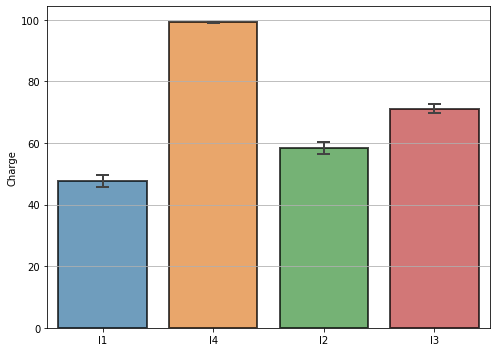

In [163]:
#mask = (df_charge['tRNA_annotation'] == 'Homo_sapiens_tRNA-Glu-CTC-1-1') & (df_charge['sample_name'] != 'U')
mask = (df_charge['sample_name'] != 'U')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

g1 = sns.barplot(ax=ax1, x='barcode', y='charge', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge');
g1.set_xlabel('');
#g1.set_xticklabels(g1.get_xticklabels(), rotation=90)



plt.tight_layout()

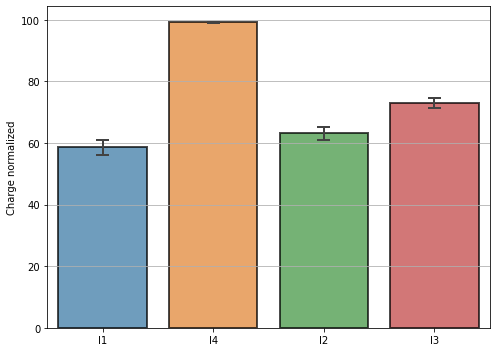

In [164]:
#mask = (df_charge['tRNA_annotation'] == 'Homo_sapiens_tRNA-Glu-CTC-1-1') & (df_charge['sample_name'] != 'U')
mask = (df_charge['sample_name'] != 'U')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

g1 = sns.barplot(ax=ax1, x='barcode', y='charge_norm', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge normalized');
g1.set_xlabel('');
#g1.set_xticklabels(g1.get_xticklabels(), rotation=90)



plt.tight_layout()

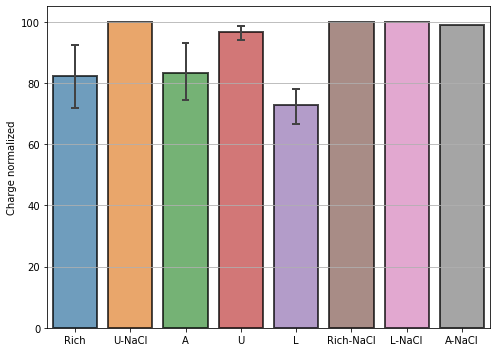

In [180]:
mask = (df_charge['tRNA_annotation'] == 'Homo_sapiens_mito_tRNA-Leu-TAA-1-1')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

g1 = sns.barplot(ax=ax1, x='sample_name', y='charge_norm', data=df_charge[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
g1.grid(True, axis='y')
g1.set_ylabel('Charge normalized');
g1.set_xlabel('');
#g1.set_xticklabels(g1.get_xticklabels(), rotation=90)



plt.tight_layout()

In [170]:
set(df_charge['tRNA_annotation'].values)

{'Escherichia_coli_str_K_12_substr_MG1655_tRNA-eColiLys-TTT-1-1',
 'Homo_sapiens_mito_tRNA-Ala-TGC-1-1',
 'Homo_sapiens_mito_tRNA-Arg-TCG-1-1',
 'Homo_sapiens_mito_tRNA-Asn-GTT-1-1',
 'Homo_sapiens_mito_tRNA-Asp-GTC-1-1',
 'Homo_sapiens_mito_tRNA-Cys-GCA-1-1',
 'Homo_sapiens_mito_tRNA-Gln-TTG-1-1',
 'Homo_sapiens_mito_tRNA-Glu-TTC-1-1',
 'Homo_sapiens_mito_tRNA-Gly-TCC-1-1',
 'Homo_sapiens_mito_tRNA-His-GTG-1-1',
 'Homo_sapiens_mito_tRNA-Ile-GAT-1-1',
 'Homo_sapiens_mito_tRNA-Leu-TAA-1-1',
 'Homo_sapiens_mito_tRNA-Leu-TAG-1-1',
 'Homo_sapiens_mito_tRNA-Lys-TTT-1-1',
 'Homo_sapiens_mito_tRNA-Lys-TTT-1-1@Homo_sapiens_tRNA-Leu-CAG-1-1',
 'Homo_sapiens_mito_tRNA-Met-CAT-1-1',
 'Homo_sapiens_mito_tRNA-Phe-GAA-1-1',
 'Homo_sapiens_mito_tRNA-Pro-TGG-1-1',
 'Homo_sapiens_mito_tRNA-Ser-GCT-1-1',
 'Homo_sapiens_mito_tRNA-Ser-TGA-1-1',
 'Homo_sapiens_mito_tRNA-Thr-TGT-1-1',
 'Homo_sapiens_mito_tRNA-Trp-TCA-1-1',
 'Homo_sapiens_mito_tRNA-Tyr-GTA-1-1',
 'Homo_sapiens_mito_tRNA-Tyr-GTA-1-1@Homo_sapi

In [165]:
stat_df['barcode'].values

array(['l3', 'l3', 'l3', ..., 'l3', 'l3', 'l3'], dtype=object)

In [164]:
stat_df['barcode'].values == 'l1'

array([False, False, False, ..., False, False, False])

In [156]:
stat_df = pd.read_csv('tmp_stat.csv', keep_default_na=False)

In [157]:
len(stat_df)

80944

In [166]:
#for barcode in ['l1', 'l2', 'l3', 'l4']:
for barcode in ['l3']:

    mask = (stat_df['3p_cover']) & (stat_df['3p_non-temp'] == '') & (stat_df['barcode'] == barcode)
    Aend = stat_df['align_3p_nt'] == 'A'
    Cend = stat_df['align_3p_nt'] == 'C'

    print(barcode)
    print(sum(mask & Aend) / sum(mask &(Aend | Cend)) *100)

l3
86.7669364603913


In [160]:
sum(stat_df[mask]['3p_non-temp'].values == '') / len(stat_df)

0.9692503459181656

In [205]:
agg_cols = ['sample_name', 'replicate', 'barcode', 'tRNA_annotation', 'tRNA_annotation_len', 'unique_annotation', 'align_3p_nt', 'codon', 'anticodon', 'amino_acid']
row_mask = (stat_df['3p_cover']) & (stat_df['3p_non-temp'] == '')

tmp = stat_df.loc[row_mask, agg_cols]
tmp['count'] = stat_df.loc[row_mask, ['align_3p_nt']]  # dummy for groupby count
gdf = tmp.groupby(agg_cols, as_index=False).agg({"count": "count"})

In [206]:
gdf

,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,align_3p_nt,codon,anticodon,amino_acid,count
0,U,3,l3,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,A,AAA,TTT,eColiLys,178
1,U,3,l3,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,C,AAA,TTT,eColiLys,149
2,U,3,l3,Homo_sapiens_mito_tRNA-Ala-TGC-1-1,72,True,A,GCA,TGC,Ala,108
3,U,3,l3,Homo_sapiens_mito_tRNA-Ala-TGC-1-1,72,True,C,GCA,TGC,Ala,15
4,U,3,l3,Homo_sapiens_mito_tRNA-Arg-TCG-1-1,68,True,A,CGA,TCG,Arg,174
...,...,...,...,...,...,...,...,...,...,...,...
705,U,3,l3,Homo_sapiens_tRNA-iMet-CAT-1-1,75,True,A,AUG,CAT,iMet,2037
706,U,3,l3,Homo_sapiens_tRNA-iMet-CAT-1-1,75,True,C,AUG,CAT,iMet,203
707,U,3,l3,Homo_sapiens_tRNA-iMet-CAT-1-1@Homo_sapiens_tR...,75,False,A,AUG,CAT,iMet,10
708,U,3,l3,Homo_sapiens_tRNA-iMet-CAT-1-1@Homo_sapiens_tR...,75,False,C,AUG,CAT,iMet,2


In [71]:
jf1 = json_files[0]
jf1

'../SWalign/U-1+2_UMI-trimmed_SWalign.json.gz'

In [72]:
'_'.join(jf1.split('/')[-1].split('_')[0:-1])

'U-1+2_UMI-trimmed'

'U-1+2'

In [50]:
str(UMIread.seq)[0:1]

'G'

In [47]:
len(str(UMIread.seq))

86

In [48]:
str(UMIread.seq)

'GTCAGGATGGCCGAGCGGTCTAAGGCACTGCGTTCAGCTCGCAGTCTCCCGTGGAGGCGTGGGTTCGGATCCCACTCCTGACACCA'

In [61]:
k = list(SWres.keys())[400]

In [62]:
SWres[k]

{'score': 58,
 'name': 'Homo_sapiens_tRNA-Trp-CCA-2-1',
 'qpos': [[2, 75]],
 'dpos': [[1, 75]],
 'qseq': 'GACCTCGTCGCGCAATGGTAGCGCATCTGACTCCA-ATCAGAAGGTTGCGTGTTCATGTCACGTCGGGGTCACCA',
 'aseq': '|||||||| ||||||||||||||| |||||||||| |||||||||||||||||||| ||||||||||||||||||',
 'dseq': 'GACCTCGTGGCGCAATGGTAGCGCGTCTGACTCCAGATCAGAAGGTTGCGTGTTCAAGTCACGTCGGGGTCACCA',
 '5p_non-temp': 'C',
 '3p_non-temp': ''}

In [63]:
tRNA_id2len[SWres[k]['name']]

75

In [80]:
SWres[k]['name'].split('@')[0]

'Homo_sapiens_tRNA-Trp-CCA-2-1'

In [128]:
SWres[k]['qseq'][-1]

'A'